# Position Time-Series Classification
Train a model with a dataset of athletes' positions as time-series data. Identify the most predictive features after the model is trained - the most obvious one will be a high position late in the race, but maybe there will be some other interesting high-influence features.

### Simplification
* restrict dataset to 1000m female races from the 2018-2019 season with lap times available
* don't engineer any additional features - just use the positions at the end of each lap

### Future Improvements
* expand dataset
* create some additional useful features

## Imports & Configuration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sktime.classification.compose import TimeSeriesForestClassifier
# from sktime.transformers.panel.tsfresh import TSFreshFeatureExtractor
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor
from sktime.utils.time_series import time_series_slope
from sktime.utils.data_container import from_2d_array_to_nested

random_seed = 0

## Select a Subset of Data

In [2]:
full_rounds = pd.read_csv('data/scraped/cleaned/rounds_splits.csv')

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15,19,20,22,23,25,26,28,29,31,34,37,40,43,46,47,49,50,52,53,55,56,58,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,109,110,113,116,119,122,125,128,131,134,137,140,143,146,149,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
rounds_df = full_rounds[(full_rounds['season'] == '2018-2019') & 
                        (full_rounds['event'] == '1000m') & 
                        (full_rounds['gender'] == 'w') & 
                        (full_rounds['laps_of_split_data'] > 1)]
rounds_df.shape

(1084, 153)

## Feature Engineering
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/)

Keeping it simple for now:

#### Features (x)
- Position of athlete at the start line and at the end of each lap of the race (including the final lap).

#### Feature to Predict (y)
- Athlete's finishing position.

In [4]:
split_column_titles = [f'lap_{i}_position' for i in range(1, 10)]
X = rounds_df[['Start Pos.'] + split_column_titles]
y = rounds_df['Place']

In [5]:
X = X.fillna(value=-1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

## Modelling
- [Univariate time-series classification with the sktime library](https://github.com/alan-turing-institute/sktime/blob/master/examples/02_classification_univariate.ipynb)
- [Survey of time-series classifiers](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97)

### Random Forest Classifier
Not specifically intended for time-series data, so although the accuracy is decent, that is because the model learns that a good position late in the race is likely is a strong indicator of winning the race. That's something we already knew.

In [7]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
print(f'Accuracy: {rf_clf.score(X_test, y_test)}')

Accuracy: 0.8202764976958525


[Text(0.5, 0, 'Lap'), Text(0, 0.5, 'Feature Importance')]

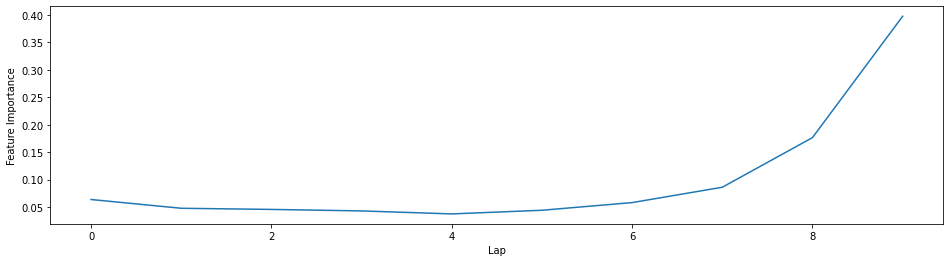

In [9]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
plt.plot(rf_clf.feature_importances_, axes=ax)
ax.set(xlabel="Lap", ylabel="Feature Importance")

### Time Series Forest Classifier

In [10]:
X_2d = from_2d_array_to_nested(X)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.2, random_state=random_seed)

In [11]:
steps = [
    ('extract', RandomIntervalFeatureExtractor(n_intervals='sqrt', features=[np.mean, np.std, time_series_slope])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)

In [12]:
tsf_clf = TimeSeriesForestClassifier(estimator=time_series_tree,
                                     n_estimators=100,
                                     criterion="entropy",
                                     bootstrap=True,
                                     oob_score=True,
                                     random_state=random_seed)
tsf_clf.fit(X_train_2d, y_train_2d)

TimeSeriesForestClassifier(bootstrap=True,
                           estimator=Pipeline(steps=[('extract',
                                                      RandomIntervalFeatureExtractor(features=[<function mean at 0x000001943CA65B80>,
                                                                                               <function std at 0x000001943CA65D30>,
                                                                                               <function time_series_slope at 0x000001944FED6F70>])),
                                                     ('clf',
                                                      DecisionTreeClassifier())]),
                           oob_score=True, random_state=0)

In [14]:
print(f'Accuracy: {tsf_clf.score(X_test_2d, y_test_2d)}')

Accuracy: 0.8294930875576036


[Text(0.5, 0, 'Lap'), Text(0, 0.5, 'Feature Importance')]

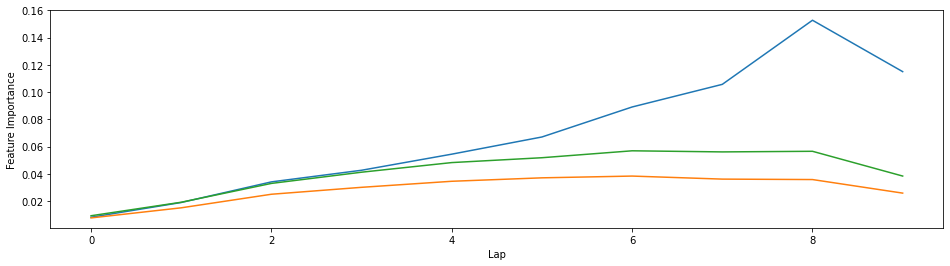

In [15]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
plt.plot(tsf_clf.feature_importances_, axes=ax)
ax.set(xlabel="Lap", ylabel="Feature Importance")

# blue = mean, orange = standard deviation, green = time series slope